# FrozenLake Mixing Agent


This notebook and the accompanying environment code is adapted from the homework assignment written by John Schulman [here](https://github.com/berkeleydeeprlcourse/homework/tree/master/hw2).



In [1]:
from frozen_lake import *
env = FrozenLakeEnvMultigoal(goal=2)
print(env.__doc__)


    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    


Let's look at what a random episode looks like.

In [2]:
# Some basic imports and setup
import numpy as np, numpy.random as nr, gym
import matplotlib.pyplot as plt
%matplotlib inline

# Seed RNGs so you get the same printouts as me
env.seed(0); from gym.spaces import prng; prng.seed(10)

NUM_ITER = 75
GAMMA = 0.95

# Generate the episode
# env.reset()
# for t in range(100):
#     env.render()
#     a = env.action_space.sample()
#     ob, rew, done, _ = env.step(a)
#     if done:
#         break
# assert done
# env.render();

In the episode above, the agent falls into a hole. Also note the stochasticity--on the first step, the DOWN action is selected, but the agent moves to the right.

We extract the relevant information from the gym Env into the MDP class below.

In [3]:
class MDP(object):
    def __init__(self, env):
        P, nS, nA, desc = MDP.env2mdp(env)
        self.P = P # state transition and reward probabilities, explained below
        self.nS = nS # number of states
        self.nA = nA # number of actions
        self.desc = desc # 2D array specifying what each grid cell means (used for plotting)
        self.env = env

    def env2mdp(env):
        return {s : {a : [tup[:3] for tup in tups] for (a, tups) in a2d.items()} for (s, a2d) in env.P.items()}, env.nS, env.nA, env.desc
    
    def get_transition_matrix(self):
        """Return a matrix with index S,A,S' -> P(S'|S,A)"""
        T = np.zeros([self.nS, self.nA, self.nS])
        for s in range(self.nS):
            for a in range(self.nA):
                transitions = self.P[s][a]
                s_a_s = {t[1]:t[0] for t in transitions}
                for s_prime in range(self.nS):
                    if s_prime in s_a_s:
                        T[s, a, s_prime] = s_a_s[s_prime]
        return T
    
mdp = MDP(env)


print("mdp.P is a two-level dict where the first key is the state and the second key is the action.")
print("The 2D grid cells are associated with indices [0, 1, 2, ..., 15] from left to right and top to down, as in")
print(np.arange(16).reshape(4,4))
print("mdp.P[state][action] is a list of tuples (probability, nextstate, reward).\n")
print("For example, state 0 is the initial state, and the transition information for s=0, a=0 is \nP[0][0] =", mdp.P[0][0], "\n")
print("As another example, state 5 corresponds to a hole in the ice, which transitions to itself with probability 1 and reward 0.")
print("P[5][0] =", mdp.P[5][0], '\n')

mdp.P is a two-level dict where the first key is the state and the second key is the action.
The 2D grid cells are associated with indices [0, 1, 2, ..., 15] from left to right and top to down, as in
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
mdp.P[state][action] is a list of tuples (probability, nextstate, reward).

For example, state 0 is the initial state, and the transition information for s=0, a=0 is 
P[0][0] = [(0.1, 0, 0.0), (0.8, 0, 0.0), (0.1, 8, 0.0)] 

As another example, state 5 corresponds to a hole in the ice, which transitions to itself with probability 1 and reward 0.
P[5][0] = [(0.1, 5, 0.0), (0.8, 4, 0.0), (0.1, 13, 0.0)] 



### Code for Mixing Agent

In [4]:
def compute_traj_likelihood(mdp, traj, actions):
    """
    Naive likelihood calculation. Should work ok for simple gridworld with short trajectories
    """
    transitions = [(traj[i], actions[i], traj[i+1]) for i in range(len(traj)-1)]
    likelihood = 1.0
    for s,a,s_prime in transitions:
        t = mdp.P[s][a]
        transition_prob = 0.0
        for p, nextstate, _ in t:
            if nextstate == s_prime:
                transition_prob = p
        likelihood *= transition_prob
    return likelihood

In [5]:
def compute_Q(T_s, V, gamma):
            Q = {}
            for a in T_s:
                Q_sa = sum(
                    [sas[0]*(sas[2] + gamma*V[sas[1]]) for sas in T_s[a]])
                Q[a] = Q_sa
            return Q

def compute_values(mdp1, mdp2, gamma, nIt):
    """
    Inputs:
        mdp: MDP
        gamma: discount factor
        nIt: number of iterations, corresponding to n above
    Outputs:
        (value_functions, policies)
        
    len(value_functions) == nIt+1 and len(policies) == n
    """
    V1s = [np.zeros(mdp1.nS)] # list of value functions contains the initial value function, which is zero
    V2s = [np.zeros(mdp2.nS)] # list of value functions contains the initial value function, which is zero
    pis = []
    for it in range(nIt):
        Vprev1 = V1s[-1]
        Vprev2 = V2s[-1]
        
        # Your code should define variables V: the bellman backup applied to Vprev
        # and pi: the greedy policy applied to Vprev
        
        
        V1 = np.zeros(mdp1.nS)
        V2 = np.zeros(mdp2.nS)

        for s in range(mdp1.nS):
            Q1 = compute_Q(mdp1.P[s], Vprev1, gamma)
            Q2 = compute_Q(mdp2.P[s], Vprev2, gamma)
            V1[s] = max(Q1.values())
            V2[s] = max(Q2.values())
        
        V1s.append(V1)
        V2s.append(V2)
    return V1s[-1], V2s[-1]
    
    
def mix_values(V1, V2, w1=1.0, w2=1.0, gamma=GAMMA):
    V = np.zeros(mdp1.nS)
    pi = np.zeros(mdp.nS)
    for s in range(mdp1.nS):
        Q1_s = compute_Q(mdp1.P[s], V1, gamma)
        Q2_s = compute_Q(mdp2.P[s], V2, gamma)
        mixed_q_s = {a: w1*Q1_s[a] + w2*Q2_s[a] for a in Q1_s}
        V[s] = max(mixed_q_s.values())
        pi[s] = max(mixed_q_s, key=lambda x:mixed_q_s[x])
    return V, pi

In [46]:
def normalize(*args):
    normalized = []
    total = sum(args)
    for arg in args:
        normalized.append(arg / total)
    return tuple(normalized)

def plot_values(V, pi, s=None):
    plt.figure(figsize=(3,3))
    plt.imshow(V.reshape(8,8), cmap='gray', interpolation='none')#, clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(8)-.5)
    ax.set_yticks(np.arange(8)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:8, 0:8]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1)}
    Pi = pi.reshape(8,8)
    for y in range(8):
        for x in range(8):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
            plt.text(x, y, str(env.desc[y,x].item().decode()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%8, s//8, 'ro')
    plt.grid(color='b', lw=2, ls='-')
    
def run_mixing_agent(true_mdp, mdp1, mdp2, p1=1.0, p2=1.0):
    s1 = mdp1.env.reset()
    s2 = mdp2.env.reset()
    assert s1 == s2, "mdp state spaces must be the same"
    s, done = s1, False
    
    Vs = []
    pi = np.zeros(mdp1.nS)
    
    w1, w2 = normalize(p1, p2)
    traj, actions = [s,], []
    V1, V2 = compute_values(mdp1, mdp2, GAMMA, NUM_ITER)

    while not done:
        V, pi = mix_values(V1, V2, w1, w2, GAMMA)
        action = pi[s]
        s, _, done, _ = true_mdp.env.step(action)
        traj.append(s)
        actions.append(action)
        l1, l2 = compute_traj_likelihood(mdp1, traj, actions), compute_traj_likelihood(mdp2, traj, actions)
        w1, w2 = normalize(p1*l1, p2*l2)
        plot_values(V, pi, s)



## Experiments

These experiments test a set of simplistic cases for the mixing agent. Player 1 wants to go to goal 1, player 2 wants to go to goal 2. In each of these experiments, one of the players has the correct belief about the environment, and we should see the mixing agent learn to go to the goal corresponding to the correct agent.

The visualizations show the mixing agent's estimated value of the states after each action.

**Experiment 1:** Player 1 believs the environment is determinsitic. Player 2 believes it isn't. The true mdp is deterministic, so the mixing agent should eventually learn to go to goal 1.

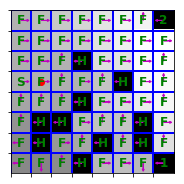

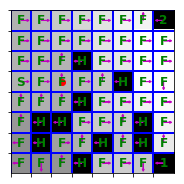

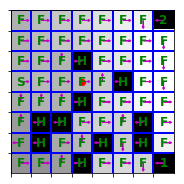

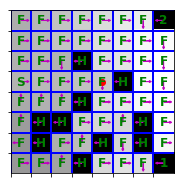

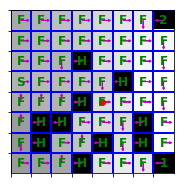

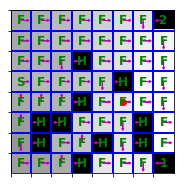

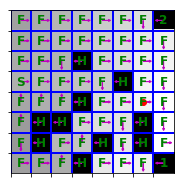

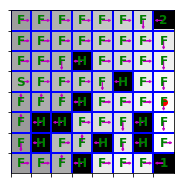

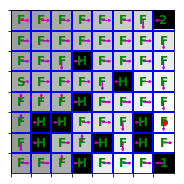

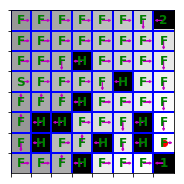

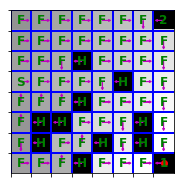

In [48]:
mdp1 = MDP(FrozenLakeEnvMultigoal(is_slippery=False, goal=1))
mdp2 = MDP(FrozenLakeEnvMultigoal(is_slippery=True, goal=2))
true_mdp = MDP(FrozenLakeEnvMultigoal(is_slippery=False, goal=1))

run_mixing_agent(true_mdp, mdp1, mdp2)

**Experiment 2:** Player 1 believs the environment is determinsitic. Player 2 believes it isn't. The true mdp is *not* deterministic, so the mixing agent should quickly learn to go to goal 2.

- **Note:** This is a pathological case where one player assigns probability 0 to a realized trajectory.

In [ ]:
mdp1 = MDP(FrozenLakeEnvMultigoal(is_slippery=False, goal=2))
mdp2 = MDP(FrozenLakeEnvMultigoal(is_slippery=True, goal=1))
true_mdp = MDP(FrozenLakeEnvMultigoal(is_slippery=True))

run_mixing_agent(true_mdp, mdp1, mdp2)

**Experiment 3:** Both players have the same (true) belief, but player 2 has a higher prior value. The mixing agent should go to goal 2.

In [ ]:
mdp1 = MDP(FrozenLakeEnvMultigoal(is_slippery=True, goal=1))
mdp2 = MDP(FrozenLakeEnvMultigoal(is_slippery=True, goal=2))
true_mdp = MDP(FrozenLakeEnvMultigoal(is_slippery=True))

run_mixing_agent(true_mdp, mdp1, mdp2, 2.0, 1.0)

In [7]:
from irl import maxent

In [8]:
mdp1 = MDP(FrozenLakeEnvMultigoal(is_slippery=False, goal=1))
mdp2 = MDP(FrozenLakeEnvMultigoal(is_slippery=True, goal=2))
true_mdp = MDP(FrozenLakeEnvMultigoal(is_slippery=False, goal=1))

feature_matrix = np.eye(mdp1.nS)
feature_matrix

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [9]:
r1 = np.zeros(64)
r2 = np.zeros(64)
r1[63] = 1.0
r2[7] = 1.0

[r1, r2]

[array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])]

In [10]:
t1 = mdp1.get_transition_matrix()
t2 = mdp2.get_transition_matrix()
t1, t2

(array([[[ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  1., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.]],
 
        [[ 0.,  1.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  1., ...,  0.,  0.,  0.]],
 
        ..., 
        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  1.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  1.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  1.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  1.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  1.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  0.,  0.,  1.],
     

In [11]:
policy1 = maxent.find_policy(mdp1.nS, r1, mdp1.nA, GAMMA, t1)
policy2 = maxent.find_policy(mdp2.nS, r2, mdp2.nA, GAMMA, t2)
policy1, policy2

(array([[  2.22851004e-01,   2.20682752e-01,   3.33615241e-01,
           2.22851004e-01],
        [  1.45731319e-01,   2.15262299e-01,   4.20841831e-01,
           2.18164551e-01],
        [  1.09250533e-01,   2.10201253e-01,   4.69802729e-01,
           2.10745486e-01],
        [  9.06296775e-02,   2.26631477e-01,   4.80703345e-01,
           2.02035501e-01],
        [  8.11260793e-02,   3.34141124e-01,   3.91709405e-01,
           1.93023391e-01],
        [  9.16386022e-02,   4.19706629e-01,   3.02689213e-01,
           1.85965556e-01],
        [  1.11361148e-01,   7.06929161e-01,   4.51296535e-04,
           1.81258395e-01],
        [  2.50000000e-01,   2.50000000e-01,   2.50000000e-01,
           2.50000000e-01],
        [  2.22970898e-01,   2.19277257e-01,   3.32590213e-01,
           2.25161632e-01],
        [  1.46365576e-01,   2.06643488e-01,   4.25724041e-01,
           2.21266894e-01],
        [  1.08093392e-01,   1.52136909e-01,   5.28445090e-01,
           2.11324609e-01],

In [12]:
def generate_trajectories(mdp, policy, T=20, D=50):
    s = mdp.env.reset()
    
    trajectories = np.zeros([D, T, 2]).astype(int)
    
    for d in range(D):
        for t in range(T):
            action = np.random.choice(range(mdp.nA), p=policy[s, :])
            trajectories[d, t, :] = [s, action]
            s, _, _, _ = mdp.env.step(action)
        s = mdp.env.reset()
    
    return trajectories

In [13]:
trajectories1 = generate_trajectories(mdp1, policy1, T=50, D=100)
trajectories2 = generate_trajectories(mdp2, policy2, T=50, D=100)

In [39]:
maxent_r1 = maxent.irl(feature_matrix=feature_matrix, n_actions=mdp1.nA, discount=GAMMA, transition_probability=t1, trajectories=trajectories1, epochs=100, learning_rate=0.01)
maxent_r2 = maxent.irl(feature_matrix=feature_matrix, n_actions=mdp2.nA, discount=GAMMA, transition_probability=t2, trajectories=trajectories2, epochs=100, learning_rate=0.01)

In [40]:
maxent_r1 -= np.min(maxent_r1)
maxent_r1 /= np.max(maxent_r1)

In [41]:
maxent_r2 -= np.min(maxent_r2)
maxent_r2 /= np.max(maxent_r2)

In [42]:
import copy

def replace_p(mdp, new_r):
    new_p = copy.deepcopy(mdp.P)
    for s in range(mdp.nS):
        for a in range(mdp.nA):
            transitions = mdp.P[s][a]
            new_transitions = [(t[0] ,t[1], new_r[int(t[1])]) for t in transitions]
            new_p[s][a] = new_transitions
    mdp.P = new_p

replace_p(mdp1, maxent_r1)
replace_p(mdp2, maxent_r2)

In [43]:
maxent_r1

array([ 0.47739608,  0.28760493,  0.11642598,  0.35912591,  0.23022439,
        0.09292061,  0.48089776,  0.48713931,  0.38336822,  0.25375103,
        0.33862187,  0.40745694,  0.3162004 ,  0.15295052,  0.43411223,
        0.33490291,  0.65162805,  0.28550716,  0.07631136,  0.0502939 ,
        0.23140913,  0.26666186,  0.3341294 ,  0.1028773 ,  0.0972221 ,
        0.19919982,  0.18459071,  0.28091751,  0.11278671,  0.39761116,
        0.13049863,  0.32859958,  0.20620832,  0.264689  ,  0.01420496,
        0.26432302,  0.05820583,  0.41228975,  0.21246841,  0.2857847 ,
        0.23957245,  0.57911206,  0.40957282,  0.21664381,  0.37708487,
        0.30040289,  0.21509073,  0.22116698,  0.20055515,  0.35899955,
        0.19855774,  0.51662943,  0.        ,  0.46049428,  0.29496148,
        0.36596535,  0.03112138,  0.02132035,  0.08121685,  0.20831504,
        0.02266375,  0.04328414,  0.08026249,  1.        ])

In [44]:
maxent_r2

array([ 0.00781774,  0.17221502,  0.10400949,  0.        ,  0.11740341,
        0.16670244,  0.28137185,  1.        ,  0.29939991,  0.06551354,
        0.00796182,  0.13018329,  0.13693833,  0.35602796,  0.38848867,
        0.30920388,  0.26969112,  0.38237956,  0.21662735,  0.58723712,
        0.09973565,  0.24594299,  0.45665017,  0.19590335,  0.3069838 ,
        0.0236182 ,  0.09499822,  0.24267486,  0.21947723,  0.25111718,
        0.23724792,  0.48455906,  0.37297486,  0.17127217,  0.30042171,
        0.14345013,  0.03052993,  0.14952607,  0.27383859,  0.42005364,
        0.20918477,  0.60469841,  0.28133504,  0.46279658,  0.20700146,
        0.05771808,  0.21166686,  0.28583379,  0.4686963 ,  0.61053275,
        0.50860367,  0.07483306,  0.24613627,  0.41824698,  0.07335191,
        0.06710404,  0.29285214,  0.11521664,  0.10457086,  0.16754973,
        0.18189207,  0.24131723,  0.44373651,  0.0385455 ])

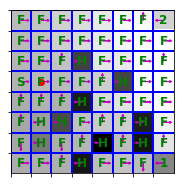

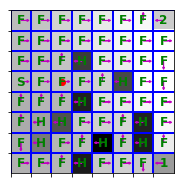

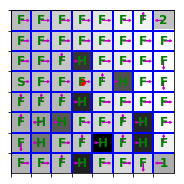

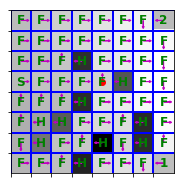

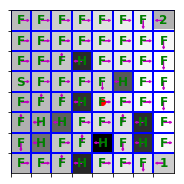

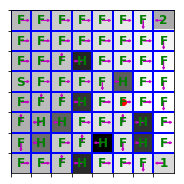

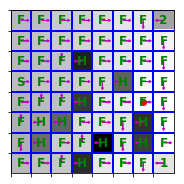

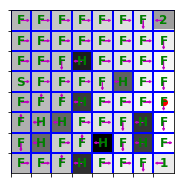

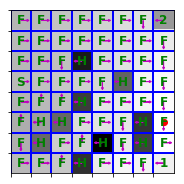

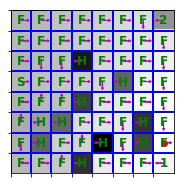

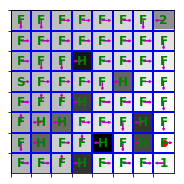

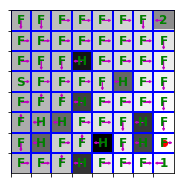

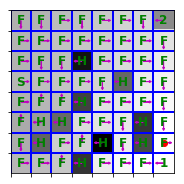

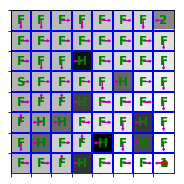

In [47]:
run_mixing_agent(true_mdp, mdp1, mdp2)